# Project Machine Learning: Group 25
### Peter Bonnarens, Lennert Franssens & Philip Kukoba

# Sprint 1 : Tabular Data

### Possible tasks:
* Thorough exploratory data analysis, e.g.:
    * Are there substantial price differences between neighbourhoods ?
    * Are there hosts with more than one listing ? How does this impact the price ?
    * What is the correlation between the review score and the price ?
    * ...

    Not enough to just show a plot! Clearly describe WHAT question you investigated, WHY you think this is a relevant question
    and WHAT you deduce/conclude from the results of your data analysis

* Are there outliers ?
* A new Airbnb owner needs to pick an appropriate price:
    * Train a model to predict the price based on a selection of features
    * Find the most similar listings
    
* ...

# Table of work (who did what)

<br>

## Exploratory Data Analysis (EDA)
|                   	| EDA step 1 	| EDA step 2A 	| EDA step 2B 	| EDA step 2C 	| EDA step 3A 	| EDA step 3B 	|
|:-----------------:	|:----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|
|  Peter Bonnarens  	|      X     	|             	|      X      	|             	|             	|             	|
| Lennert Franssens 	|      X     	|      X      	|             	|             	|      X      	|             	|
|   Philip Kukoba   	|      X     	|             	|             	|      X      	|             	|             	|

<br>

## Linear Regression Model (LR)
|                   	| LR step 1 	| LR step 2 	| LR step 3 	| LR step 4 	|
|:-----------------:	|:---------:	|:---------:	|:---------:	|:---------:	|
|  Peter Bonnarens  	|     X     	|           	|           	|     X     	|
| Lennert Franssens 	|           	|           	|           	|           	|
|   Philip Kukoba   	|           	|           	|           	|           	|

<br>

## K Nearest Neighbors Model (KNN)
|                   	| KNN step 1 	| KNN step 2 	| KNN step 3 	| KNN step 4 	|
|:-----------------:	|:----------:	|:----------:	|:----------:	|:----------:	|
|  Peter Bonnarens  	|            	|            	|            	|            	|
| Lennert Franssens 	|            	|            	|            	|            	|
|   Philip Kukoba   	|            	|            	|            	|            	|

# Exploratory Data Analysis (EDA)

### MERK OP: er zijn een paar rijen verschoven (bepaalde kolom die weg is ofzo): shift deze rijen!!!

1. host_response_time en host_response_rate: regex om tijdsinterval te kennen, slechte waarden van host_response_time vervangen door juiste waarde in host_response_rate (zie print(listings[ (~listings["host_response_rate"].isnull()) & (~listings["host_response_rate"].str.match('.*%', na=False)) ]) ) en percentage teken bij host_response_rate wegdoen - is omgezet naar een rating (gemakkelijker)
2. host acceptance rate: % wegdoen en omzetten naar float. - % is weggedaan, nog omzetten naar float.. (kan nan niet omzetten naar float)
3. host total listings count: omzetten naar float
4. host verifications: omzetten naar lengte van de array om te kijken op hoeveel manieren een host kan geverifieerd worden (meer trustworthy?)
5. host has profile pic: omzetten naar 0 of 1 (misschien meer geboekt als wel profile pic?)
6. host identity verified: omzetten naar 0 of 1 (misschien meer geboekt als verified?)
7.

## Step 1: imports & loading the dataset

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20,16

%matplotlib inline

# loading the dataset into pandas dataframe
listings = pd.read_csv("data/listings.csv")

## Step 2: preprocessing

### 2A : Shift rows
We noticed that some rows in the dataset contained data that was shifted 1 column to the right starting from the 'host_id' column. Instead of removing these rows from the dataset, we decided to shift these rows 1 column back to the left.

In [2]:
# find lines to shift and add them to a mask - we've found that some lines are shifted 1 to the right beginning on the host_id column (that now contains garbage data)
shifted_lines = listings[pd.to_numeric(listings["host_verifications"], errors='coerce').notnull()].id
mask = listings['id'].isin(shifted_lines)

# shift lines 1 to the left
listings.loc[mask, 'host_id':'reviews_per_month'] = listings.loc[mask, 'host_id':'reviews_per_month'].shift(-1, axis=1)


### 2B : Feature subset selection
Before we start cleaning up the data, we first extract the features we think will be useful to explore during this sprint.

In [3]:
# filter columns
listings = listings[["id", "name", "host_id", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_total_listings_count", "host_verifications", "host_has_profile_pic","host_identity_verified", "neighbourhood_cleansed", "room_type", "accommodates", "price", "minimum_nights", "minimum_nights", "maximum_nights", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "number_of_reviews", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value"]]
listings.head()

,id,name,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,...,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,187870,Luxury studio 'Spiegelhof' in the centre of Ghent,904277,within an hour,100%,100%,2,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,...,2.0,1125.0,419,4.85,4.90,4.95,4.90,4.87,4.58,4.85
1,203806,Flat close to Sint-Pieters Station!,999847,within an hour,100%,88%,3,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,...,1.7,1125.0,287,4.59,4.72,4.73,4.80,4.79,4.49,4.54
2,204245,Modern studio's in Ghent centre,1003009,within a day,100%,100%,2,"['email', 'phone', 'reviews']",t,f,...,1.3,14.0,30,4.79,4.73,4.93,4.83,4.70,4.97,4.63
3,216715,converted loft,911466,within an hour,100%,100%,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,...,2.0,1125.0,474,4.75,4.81,4.90,4.89,4.85,4.89,4.76
4,252269,Large & bright town House - Center Ghent - max 8p,1195314,within a few hours,100%,91%,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,...,2.0,120.0,154,4.89,4.92,4.93,4.92,4.97,4.98,4.72


### 2C : Host response time/rate

In [4]:
# host_response_time
# 0 = best resposne time, 1,2... worse
# listings["host_response_time"].unique()

listings["host_response_time_rating"] = [0 if x == 'within an hour' 
                                         else 1 if x == 'within a few hours' 
                                         else 2 if x == 'within a day' 
                                         else 3 if x == 'a few days or more' 
                                         else None 
                                         for x in listings["host_response_time"]]
listings = listings.drop(columns=["host_response_time"])

#host_response_rate strip trailing % char

listings["host_response_rate"] = [None if x == None else str(x).rstrip('%') for x in listings["host_response_rate"]]
listings["host_response_rate"].unique()




array(['100', 'nan', '50', '90', '0', '88', '57', '78', '71', '67', '83',
       '95', '91', '70', '80', '86', '92', '94', '63', '98', '99', '75',
       '60', '89', '40', '30'], dtype=object)

## Step 3 : plots

### 3A : Correlation matrix

<AxesSubplot:>

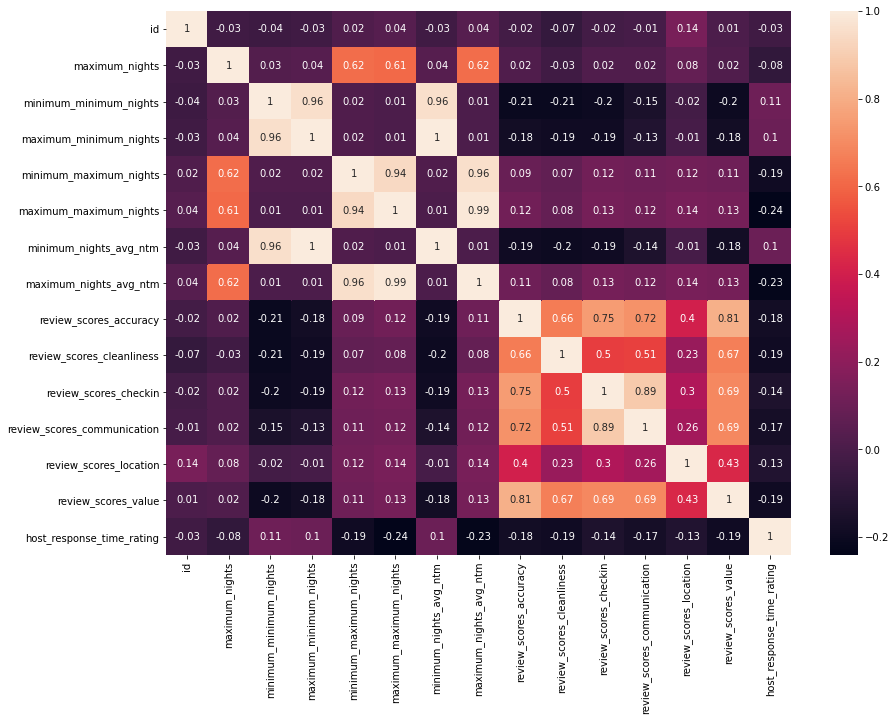

In [5]:
correlation_matrix = listings.corr().round(2)
plt.figure(figsize=(14,10))
sns.heatmap(data=correlation_matrix, annot=True)

# Linear Regression Model

## Step 1 : Train - Test - Split

In [ ]:
from sklearn.model_selection import train_test_split

# TODO: insert chosen features into X
X = pd.concat((), axis=1)
Y = listings["price"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Step 2: Normalizing the data

In [ ]:
# TODO
# formule: x-xmin/xmax-xmin

## Step 3 : Training the model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

y_train_predict = lin_model.predict(X_train)
y_test_predict = lin_model.predict(X_test)

## Step 4 : Measure the performance of the model

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# model evaluation for training set
n_train = len(X_train)  # sample size
p_train = len(X_train.columns)  # number of independent variables
R2_train = r2_score(Y_train, y_train_predict)
RMSE_train = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
# use the adjusted R² score to counter accidental increase of score with number of input features.
adj_R2_train = 1 - ((1-R2_train) * (n_train-1)/(n_train-p_train-1))   #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

print("Model train performance")
print("--------------------------------------")
print('RMSE is {}'.format(RMSE_train))
print('R2 score is {}'.format(R2_train))
print('adjusted R2 score is {}'.format(adj_R2_train))
print("\n")

# model evaluation for testing set
n_test = len(X_test)
p_test = len(X_test.columns)
R2_test = r2_score(Y_test, y_test_predict)
RMSE_test = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
adj_R2_test = 1 - ((1-R2_test) * (n_test-1)/(n_test-p_test-1))   #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

print("Model test performance")
print("--------------------------------------")
print('RMSE is {}'.format(RMSE_test))
print('R2 score is {}'.format(R2_test))
print('adjusted R2 score is {}'.format(adj_R2_test))
print("\n")


print("Model parameters")
print("--------------------------------------")
print(lin_model.coef_)
print(lin_model.intercept_)

# K Nearest Neighbors Model

## Step 1 : Train - Test - Split

## Step 2: Normalizing the data

## Step 3 : Training the model

## Step 4: Measure the performance of the model